<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Elucidating the Design Space of Diffusion-Based Generative Models

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torchvision
import PIL
import torch
from IPython.display import Image as showImage
import dnnlib
import pickle
import matplotlib.image as mpimg
from matplotlib import rcParams
from PIL import Image
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Introduction

Generative imaging has been revolutionized by denoising diffusion techniques, which innovatively transform noisy images into refined data samples. The goal of diffusion models is to learn a diffusion process that generates the probability distribution of a given dataset. The theoretical foundations of these models are rooted in Markov chains and stochastic differential equations. This tutorial, based on '[Elucidating the Design Space of Diffusion-Based Models](https://research.nvidia.com/publication/2022-11_elucidating-design-space-diffusion-based-generative-models)' and the associated [blog]('https://developer.nvidia.com/blog/generative-ai-research-spotlight-demystifying-diffusion-based-models/'), delves into the intricacies and design choices in diffusion model literature. By analyzing former works on diffusion models and their specific design choices, we aim to construct a comprehensive table of best practices for each of these design choices. The former work presents the Variance Preserving (VP), Variance Exploding (VE), the DDPM, and iDDPM methods, which are fundamentally different in terms of architectures, training methods, and more.

This tutorial aims to demystify the fundamentals and guide you through state-of-the-art practices for optimizing quality and computational efficiency, maintaining intuition and precision throughout.
The ultimate goal is to understand the following table, where each entry represents an optimized design choice, drawing from the theory presented in the paper. If any concept seems unfamiliar, don't worry, we will cover all of this throughout the notebook.


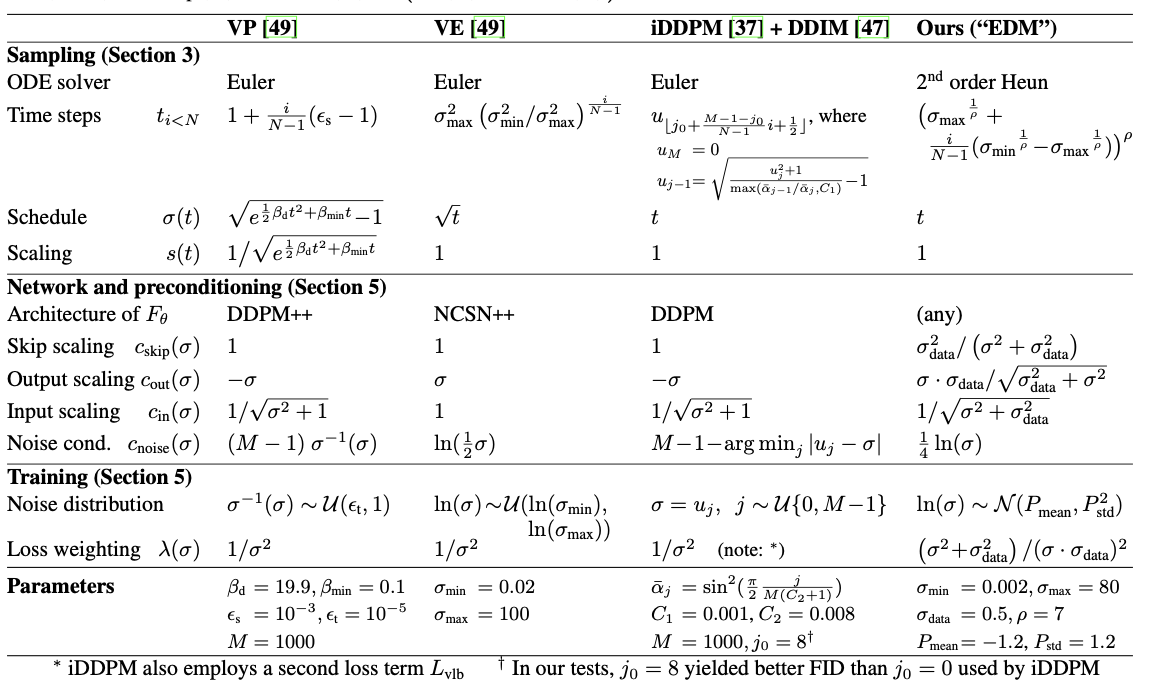

In [6]:
showImage('./figure/main_table.png',width=1000)

> **The remainder of this tutorial will be divided into three parts:**

- [A refresher on the Diffusion Models](#a-refresher-on-the-diffusion-models)
- [Sampling Choices](#sampling-choices)
- [The Neural Denoiser, aka score function](#the-neural-denoiser-aka-score-function)

(The detailed examination of neural network architectures for diffusion models falls outside the scope of this tutorial.)


# A Refresher on the Diffusion Models

In this section, we'll revisit the fundamentals to build a solid understanding of diffusion models, drawing insights from the differential equation framework outlined in ['Score-Based Generative Modeling through Stochastic Differential Equations'](https://arxiv.org/abs/2011.13456). This section is inspired by the [Yang Song blog](http://yang-song.net/blog/2021/score/#score-based-generative-modeling-with-stochastic-differential-equations-sdes), who is the main author of the article.

Let's Start with a Relatable Example Consider an image of a parrot, denoted as \(X\). Contrary to what you might expect, we begin by adding noise to the image of the parrot. This initial step, while seemingly counterintuitive, plays a crucial role in the diffusion process that we will explore in depth throughout this section.


In [ ]:
# Load the image
image_path = './figure/RGB_24bits_palette_sample_image.png' #You can put the link of your own (RGB) image! 
image = Image.open(image_path)
showImage(image_path)


In [ ]:
# Transform the image to a tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor()])

x = transform(image)

# Setup a subplot grid
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 2))

# Apply noise and display
for step in range(10):
    x = x + 0.1 * torch.randn_like(x)
    
    # Convert the tensor back to an image
    img = transforms.ToPILImage()(x.cpu()).convert("RGB")
    
    # Display the image in a subplot
    ax = axes[step]
    ax.imshow(img)
    ax.set_title(f"Step {step}")
    ax.axis('off')

plt.show()


This process can be regarded as a stochastic differential equation (SDE) that corresponds to a simple SDE, $\text{d}\mathbf{x} = \text{d}\omega_t$. This equation suggests that the change in the image $\mathbf{x}$ over a short time step is equivalent to random white noise. 
Diffusion processes, especially within the realm of generative models, are interpreted as solutions to stochastic differential equations (SDEs). Generally, an SDE can be represented in the form:
$$
\mathrm{d} \mathbf{x} = \mathbf{f}(\mathbf{x}, t) \, \mathrm{d}t + g(t) \, \mathrm{d} \mathbf{w}.
$$
Here, $\omega_t$ denotes the standard Wiener process, and $\mathbf{f}(\cdot,t) : \mathbb{R}^d \rightarrow \mathbb{R}^d$ and $g(\cdot) : \mathbb{R} \rightarrow \mathbb{R}$ represent the drift and diffusion coefficients, respectively, with $d$ being the dimensionality of the dataset. These coefficients are chosen differently in the literature. The authors of the articles base their study on the variance preserving (VP) and variance exploding (VE) formulations, with $\mathbf{f}(\cdot)$ always taking the form $\mathbf{f}(x,t) = f(t) \mathbf{x}$, where $f(\cdot) : \mathbb{R} \rightarrow \mathbb{R}$. Consequently, the SDE can be equivalently written as:
$$
\mathrm{d}x = f(t) \mathbf{x} \, \mathrm{d}t + g(t) \, \mathrm{d}\omega_t. 


A nice aspect of differential equations is their geometric interpretation, which offers a straightforward visualization of the processes. This is particularly illuminating in the context of diffusion models, where the process can be visualized as the image undergoing a random walk. This random walk is analogous to the Brownian motion, or Wiener process, in the pixel value space.

To simplify, if we consider $\mathbf{x}$ to represent just a single number (imagining it as a "single pixel image"), we can plot its evolution over time. This graph effectively illustrates how diffusion models function, albeit on a much more comprehensible scale. The actual process occurs in significantly higher dimensions—corresponding to the number of pixels in our image—making it impossible to directly visualize on a two-dimensional monitor. However, the principle remains the same.


In [ ]:
# Choose a specific pixel position (x, y)
x_pos, y_pos = 10, 10  # Example coordinates

# List to store pixel values
pixel_values = []

# Apply noise and display
for step in range(1000):
    x = x + 0.1 * torch.randn_like(x)
    
    # Record the pixel value
    pixel_value = x[ :, x_pos, y_pos]  # Assuming x is a 3D tensor (batch, channel, height, width)
    pixel_values.append(pixel_value.mean().item())

# Plot the pixel values
plt.figure(figsize=(10, 4))
plt.plot(pixel_values)
plt.title("Pixel Value Change Over Diffusion Steps")
plt.xlabel("Step")
plt.ylabel("Pixel Value")
plt.show()

Studying this evolution using many different starting images and random paths, we begin to observe some order within the chaos. Imagine stacking numerous paths on top of one another. On average, these paths create a shape that changes over time. In this exploration, we will be using the CIFAR-10 dataset.

In [ ]:
# Transformations including normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load CIFAR-10 dataset with normalization
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# DataLoader 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40, shuffle=False)
images, _ = next(iter(trainloader))

# Function to show an image
def imshow(img):
    # Unnormalize the images for visualization
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(images, nrow=5))  # Adjust nrow for better layout




In [ ]:
# Select 40 pixels, one on each image
temp1=np.linspace(16,x.shape[1]-16,8)
temp2=np.linspace(16,x.shape[2]-16,5)
pixels=[(int(i),int(j)) for i in temp1 for j in temp2]

# Store pixel values for each pixel
pixel_values = {pixel: [] for pixel in pixels}

x=torchvision.utils.make_grid(images, nrow=5) 

# Apply noise and track pixel values
for step in range(5000):
    x = x + 0.1 * torch.randn_like(x)

    
    for pixel in pixels:
        value = x[:, pixel[0], pixel[1]].mean().item()
        pixel_values[pixel].append(value)

# Plot the pixel values for each tracked pixel
plt.figure(figsize=(12, 6))
for pixel, values in pixel_values.items():
    plt.plot(values)

plt.title("Pixel Value Changes Over 5000 Diffusion Steps for 40 Different Images")
plt.xlabel("Step")
plt.ylabel("Pixel Value")
plt.show()

The complex pattern of data at the left edge gradually mixes and simplifies into a featureless blob at the right edge. 

In [ ]:
test=[]
for pixel, values in pixel_values.items():
    test.append(values[-1])
plt.hist(test, bins=8)
plt.title('Last timestep pixel distribution')

The goal of generative modeling is to find a method to sample novel images from the true hidden data distribution on the left, as shown in the previous figure. In other words, we aim to generate new images that could have been in the dataset but weren’t. Sampling from the pure-noise state on the right is straightforward using `randn`. The question then arises: Is it possible to run the noising process in reverse, thereby obtaining random samples of clean images, as illustrated in the figure below?

<div>
<img src="https://developer-blogs.nvidia.com/wp-content/uploads/2023/12/image8.gif" width="800"/>
</div>

What ensures that following a random path starting from the right edge leads to a proper image at the left edge, rather than just more noise? Intuitively, we might say that some kind of additional force is needed to gently pull the image towards the dataset at each time-step.

The theory of stochastic differential equations (SDEs) offers a beautiful solution. It allows for the reversal of time direction, which automatically introduces an extra term acting as the data-attraction force. This force pulls the noisy image towards its mean-square optimal denoising. This optimal denoising can be estimated with a trained neural network:

$$
dx = dw_t - \left[\text{denoise}(x, \sigma) - \frac{x}{\sigma^2}\right] dt
$$

where:

- $dx$ represents the infinitesimal change in the image $x$ over time.
- $dw_t$ is the Wiener process, capturing the randomness of the path.
- $\text{denoise}(x, \sigma)$ is the function applied to denoise the image $x$ at noise level $\sigma$, estimated by the neural network.
- $\frac{x}{\sigma^2}$ acts as a scaling factor, adjusting the image $x$ based on the current noise level $\sigma$.
- $dt$ is the infinitesimal step in time, moving the process towards generating a clean image.

In a more formal way, we can reverse the perturbation process for sample generation by using the reverse SDE. Importantly, any SDE has a corresponding reverse SDE whose closed form is given by:

\begin{align}
  d\mathbf{x} = [\mathbf{f}(\mathbf{x}, t) - g^2(t)\nabla_{\mathbf{x}}\log p_t(\mathbf{x})] dt + g(t) d\bar{\mathbf{w}},
\end{align}
Here  $dt$ represents a negative infinitesimal time step, since the SDE  needs to be solved backwards in time (from $T$ to $0$). In order to compute the reverse SDE, we need to estimate 
$\log p_t(\mathbf{x})$, which is also called the score function of $p_t(x)$ and had the proprety that it can be evaluated by denoising and trained via a neural network, it was the $\text{denoise}(x, \sigma)$. that we see previsously.

In a more formal context, we can reverse the perturbation process for sample generation by utilizing the reverse SDE. Notably, any SDE has a corresponding reverse SDE, the closed form of which is given by:

\begin{align}
  d\mathbf{x} = [\mathbf{f}(\mathbf{x}, t) - g^2(t)\nabla_{\mathbf{x}}\log p_t(\mathbf{x})] dt + g(t) d\bar{\mathbf{w}},
\end{align}

Here, $dt$ represents a negative infinitesimal time step, indicating that the SDE is solved backwards in time (from $T$ to $0$). To compute the reverse SDE, it's necessary to estimate $\log p_t(\mathbf{x})$, which is also known as the score function of $p_t(x)$. The score function is essentially the gradient of the log probability density with respect to the data, $\mathbf{x}$, at time $t$. It provides a measure of how the probability density function $p_t(\mathbf{x})$ changes as the data $\mathbf{x}$ changes. Estimating the score function allows us to determine the direction in which to adjust $\mathbf{x}$ at each step of the reverse process to increase the likelihood of generating samples that resemble the true data distribution. The estimation of $\log p_t(\mathbf{x})$ can be achieved through a technique known as score matching, where a neural network is trained to approximate this score function. The network learns to denoise the input by predicting the gradient of the log probability, effectively guiding the reverse diffusion process.

The operation $\text{denoise}(x, \sigma)$ mentioned previously corresponds to the application of this trained neural network. It uses the current estimate of the noise level, $\sigma$, to adjust $\mathbf{x}$ towards what the model believes to be a more probable state under the true data distribution. Through iterative application of this process, the model can reverse the diffusion process, starting from pure noise and gradually refining the samples into coherent images or data points that closely resemble the original dataset.

The overall intuition of score-based generative modeling with SDEs can be summarized in the illustration below
<div>
<img src="http://yang-song.net/assets/img/score/sde_schematic.jpg" width="900"/>
</div>

You can adjust the weight of the two terms, $dt$ and $dw_t$, as long as you carefully maintain the total rate of noise reduction unchanged. Taking this idea to the extreme, where noise is removed exclusively, leads to a fully deterministic ordinary differential equation (ODE) without any random component. More generally, it has been proven that it is possible to convert any stochastic differential equation (SDE) into an ordinary differential equation. The corresponding ODE of an SDE is named the probability flow ODE.

For any SDE of the form:

$$
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) d t + g(t) d \mathbf{w},
\end{align*}
$$

there exists an associated ordinary differential equation (ODE):

$$
\begin{align*}
d \mathbf{x} = \left[\mathbf{f}(\mathbf{x}, t) - \frac{1}{2} g(t)^2 \nabla_\mathbf{x} \log p_t(\mathbf{x})\right] dt.
\end{align*}
$$

The evolution then follows a smooth trajectory, and the image simply fades in from underneath the fixed noise.

<div>
<img src="https://developer-blogs.nvidia.com/wp-content/uploads/2023/12/reverse-time-evolution-path-image.gif" width="800"/>
</div>


This representation provides a much clearer view of the sampling dynamics, so we will be examining this approach first before returning to stochasticity later. The strategy now is to follow the ODE path for generation. This is achieved through discretization; we take small, microscopic steps and reduce the time. For any change in time, we expect a corresponding jump in state. The ODE formula informs us how much the image changes, and again, the ODE step is evaluated through a neural network, which dictates our next move. This process is repeated until we reach time zero, and this generated sample is the result of our procedure. If we were manipulating an SDE, we would also inject noise at each step, but we will delve into that later.

<div>
<img src="https://developer-blogs.nvidia.com/wp-content/uploads/2023/12/step-direction-diagram-denoising-diffusion.png" width="700"/>
</div>

To sum up what we saw in this part, a diffusion model consists of three major components: the forward process, the reverse process, and the sampling procedure.

# Sampling Choices

## Source of Errors

Having recapped some intuitive foundations for generating images, we now aim to identify and generalize design choices from various methods in formulating both Ordinary Differential Equations (ODEs) and Stochastic Differential Equations (SDEs). Before we proceed, it's crucial to understand potential pitfalls in this process and the sources of errors. One significant source of error is diverging from the intended outcome, ending up at a different location than planned. This concept is illustrated in the following image:


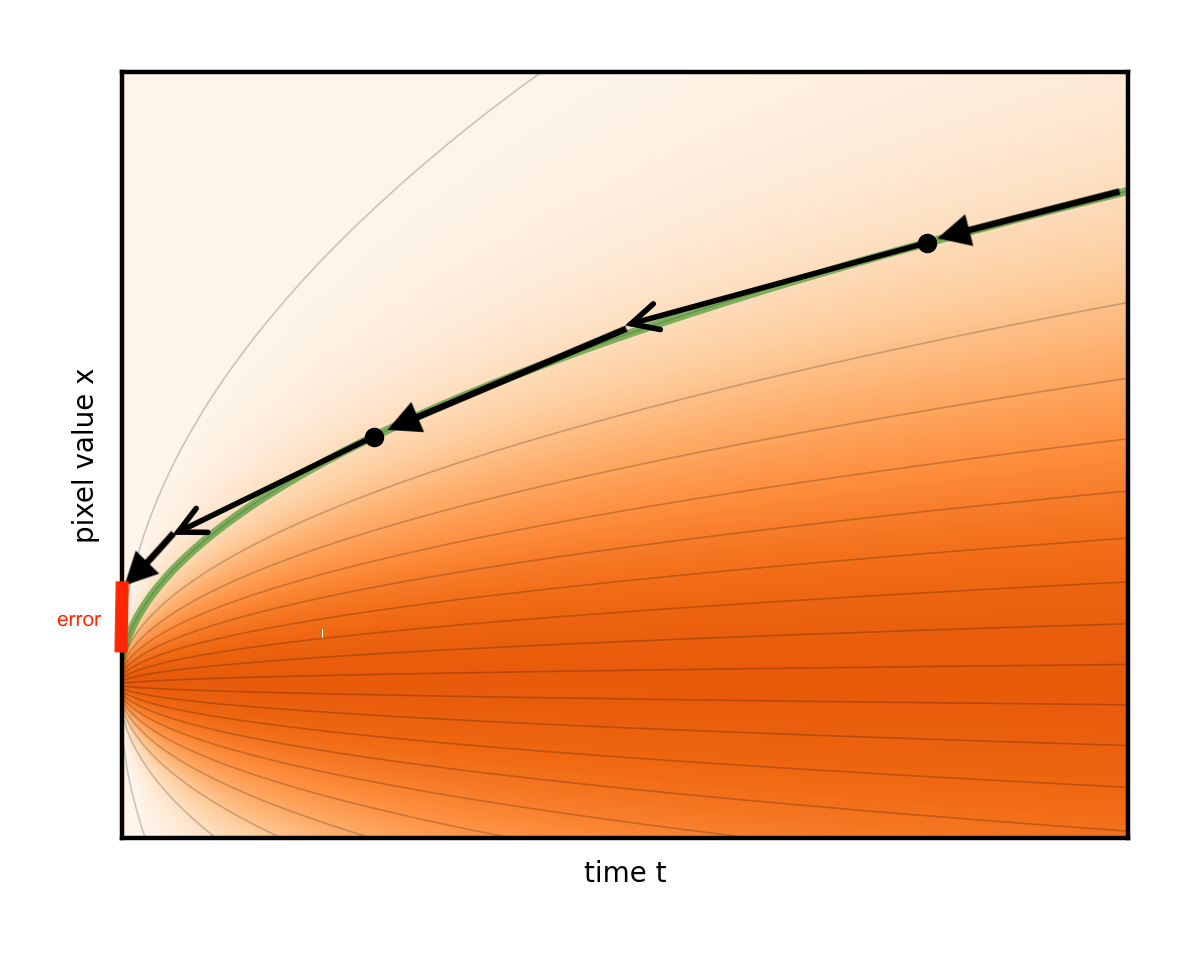

In [26]:
showImage('./figure/ODE_ERROR.png', width=700)

Errors in the generation process can arise from several sources. One such source is the neural network providing incorrect directions, failing to accurately approximate the true score of the data. Another problem come from attempting to approximate a continuous trajectory using finite, linear steps (represented by the black arrows in diagrams). If the steps taken are too large, the approximation may significantly diverge from the actual trajectory of the ODE, a common challenge in the physical simulation of ODEs.

A straightforward solution might be to simply increase the number of steps taken, thereby reducing the size of each step and improving accuracy. However, this directly leads to increased computational cost for generating an image, which is precisely what we aim to avoid. A key contribution of the discussed paper is the assertion that these two problems—accurate approximation and computational efficiency—should be addressed independently. The method of sampling does not need to be linked to how we train our neural network, allowing for a decoupling of these processes. Indeed, we will focus on exploring sampling strategies first and revisit training methodologies later.

In the previous example we examined, noise was added at a constant rate (or at every time step), meaning the standard deviation grows as the square root of time, i.e., $\sigma(t)=\sqrt{t}$. This is because the variance increases linearly with time, which results in the standard deviation growing at the square root rate. If we add noise at a different rate, we end up with a different Ordinary Differential Equation (ODE). In diffusion model literature, the term "noise schedule" refers to the strategy or plan for how the noise level, $\sigma$, changes over time or across steps. There are many different noise schedules, each inducing a unique ODE. The following figure illustrates a few different ODEs that result from various noise schedule choices.

<div>
<img src="https://developer-blogs.nvidia.com/wp-content/uploads/2023/12/different-noise-schedules-flow-line-gif-1.gif" width="700"/>
</div>

In the code below, you have the opportunity to adjust the noise schedule and observe the varying paths taken by pixels. Experiment with different noise schedules to see how they influence the diffusion process. Feel free to modify the noise schedule parameters to explore different outcomes! 


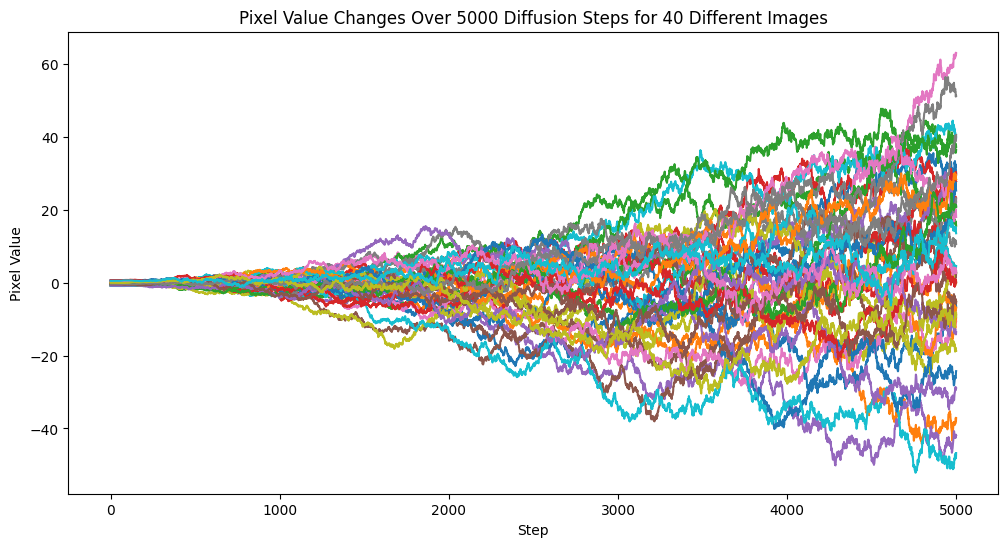

In [27]:
# Define your own schedule
def sigma(t, max_steps=5000):
    # return np.sqrt(t) #Linear one that we use before ! 
    return t/max_steps

# Select 40 pixels, one on each image
temp1=np.linspace(16,x.shape[1]-16,8)
temp2=np.linspace(16,x.shape[2]-16,5)
pixels=[(int(i),int(j)) for i in temp1 for j in temp2]

# Dictionary to store pixel values for each pixel
pixel_values = {pixel: [] for pixel in pixels}

x=torchvision.utils.make_grid(images, nrow=5) # We've used the image shown above because it has several sub-images. 
for step in range(5000):
    current_sigma = sigma(step)
    # Add noise based on the current sigma
    x = x + current_sigma * torch.randn_like(x)
    for pixel in pixels:
        value = x[:, pixel[0], pixel[1]].mean().item()
        pixel_values[pixel].append(value)


plt.figure(figsize=(12, 6))
for pixel, values in pixel_values.items():
    plt.plot(values, label=f'Pixel {pixel}')

plt.title("Pixel Value Changes Over 5000 Diffusion Steps for 40 Different Images")
plt.xlabel("Step")
plt.ylabel("Pixel Value")
plt.show()

## Select the Design Choices

To generalize this concept, the authors have reformulated the model in a way that clarifies the impact of varying noise levels over time. Specifically, they demonstrate that it's possible to rewrite the Ordinary Differential Equation (ODE) to directly specify any $\sigma(t)$, thus proving:

$$dx = -\dot{\sigma}(t) \sigma(t) \nabla_x \log p(x; \sigma(t)) dt.$$

For the mathematical proof, please refer to [appendix B.2](https://arxiv.org/pdf/2206.00364.pdf) of the main article. At this point, one might wonder: why undertake such a reformulation?

Observing the follwing images, we notice that at high times, minimal changes occur until a certain point, where significant curvature begins to emerge. It's in regions of high curvature that we must tread carefully. There are two strategies to address this:

- Firstly, we could take shorter steps in the more challenging parts, typically at lower noise levels where the image's details are refined.
- Alternatively, we can adjust the noise schedule to allocate more time to these critical levels.

And there we have it, the identification of the first pair of design choices: the time steps $t_{i<N}$ and the noise schedule $\sigma(t)$!


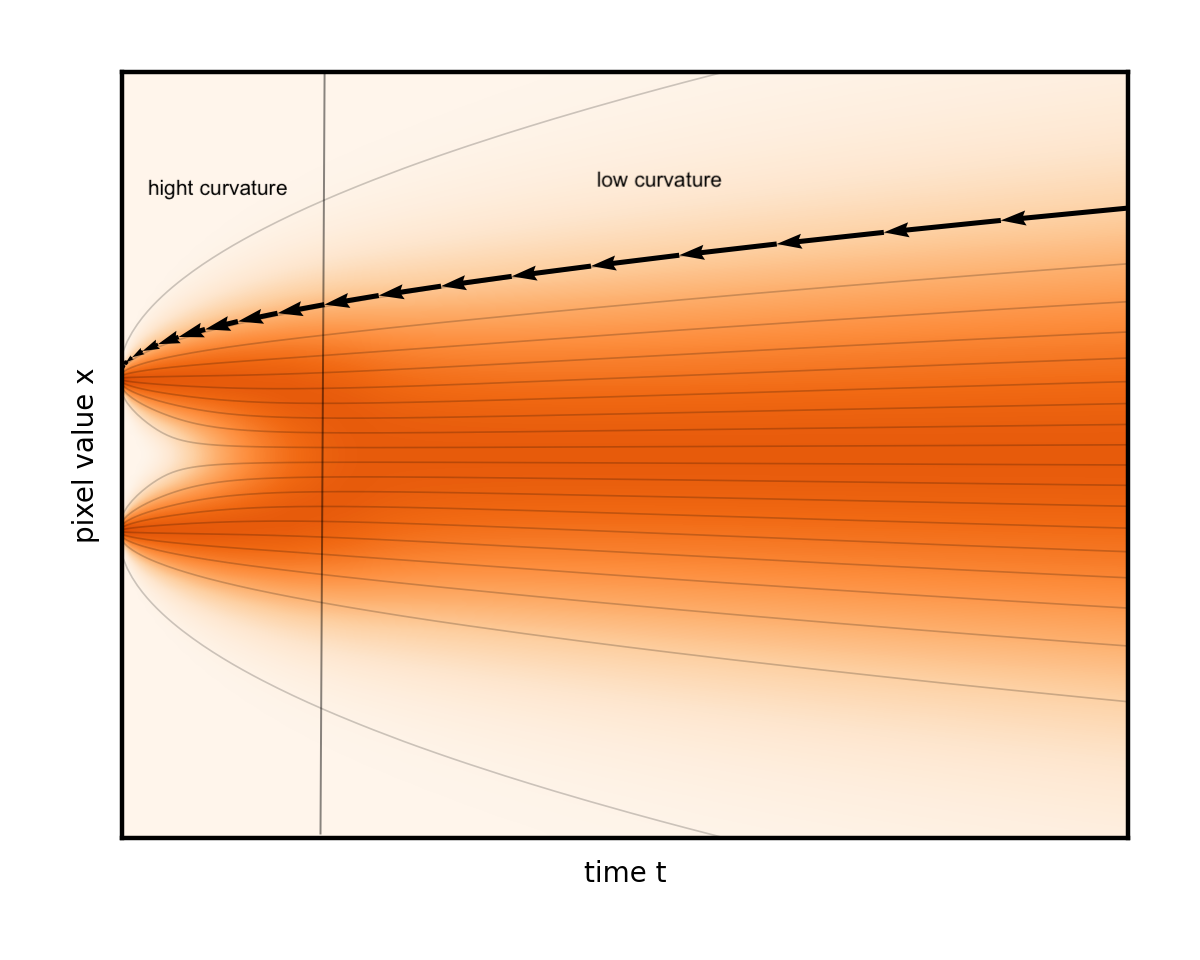

In [29]:
showImage('./figure/time-steps-long-at-high-noise-levels.png', width=750)

Let's take a step back and look at our noisy images:

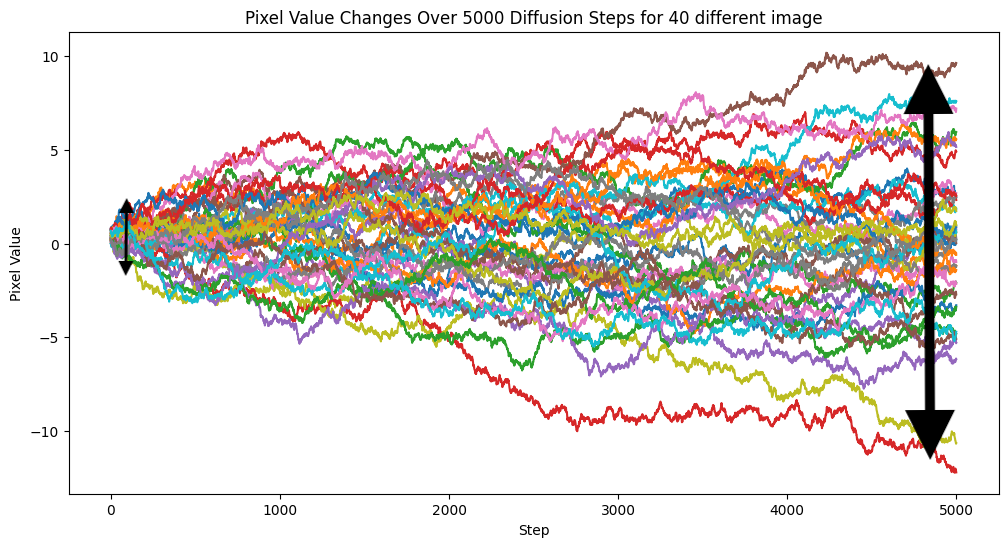

In [30]:
showImage('./figure/noisy_image.png')

We observe that the noise level at the end is significantly larger compared to the beginning, even though our previous examples focused on small time intervals. In practice, we introduce substantially more noise! The problem arises when, without any adjustments, the signal magnitude increases alongside the noise level, resulting in tensor values that are much larger than those at lower noise levels. This scenario is problematic for neural network training, as handling such large values can be challenging (especially since we eventually need to train a neural network for the decoding part).

To address this issue, we employ a technique known as the Variance Preserving Scale Schedule (VP), where we introduce an additional scaling factor $s(t)=\frac{1}{\sigma^2(t)+1}$. This scaling allows us to compress the signal magnitude into a 'tube,' effectively stabilizing the input values for the neural network. This approach is one way to optimize the training process.

We implement this solution in the code below. Through this implementation, you'll observe how the amplitude of pixels is effectively constrained between -1.5 and 1.5.

In [ ]:
def sigma(t, max_steps=5000):
    return t / max_steps

def s(t, max_steps=5000):
    sig = sigma(t, max_steps)
    return 1 / (sig**2 + 1)


x = torchvision.utils.make_grid(images, nrow=5)
pixel_values = {pixel: [] for pixel in pixels}
total_steps = 5000

for step in range(total_steps):
    current_sigma = sigma(step, total_steps)
    current_s = s(step, total_steps)
    
    # Apply noise based on the current sigma and scale the image by s(t)
    noise = current_sigma * torch.randn_like(x)
    x = current_s * (x + noise)

    # Record the pixel values
    for pixel in pixels:
        value = x[:, pixel[0], pixel[1]].mean().item()
        pixel_values[pixel].append(value)

# Plot the pixel values for each tracked pixel
plt.figure(figsize=(12, 6))
for pixel, values in pixel_values.items():
    plt.plot(values)

plt.title("Pixel Value Changes Over 5000 Diffusion Steps with Scale Schedule")
plt.xlabel("Step")
plt.ylabel("Pixel Value")

plt.show()


Another approach involves incorporating an initial scaling layer into our neural network that leverages the known signal scale. We will take a closer look into how to select the appropriate scale in practice later on. This introduces another set of design choices: the scaling function $s(t)$ and the input scaling of the neural network, denoted as $c_{in}(\sigma)$. With these considerations in mind, we can revisit the first table presented in the introduction. This table not only explains these design choices but also compares them with the choices made in other methods:


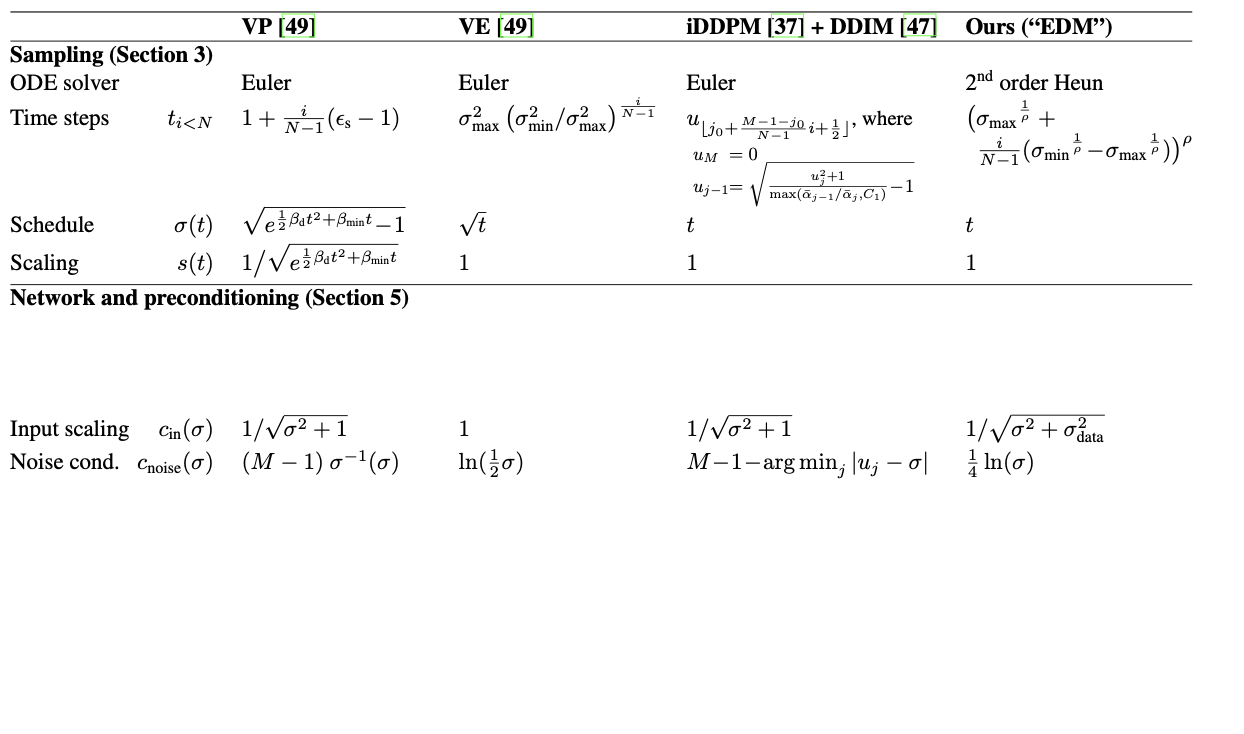

In [ ]:
showImage('./figure/recap_table.png',width=700)

We will initially utilize pre-trained networks and revisit the topic of training towards the end of our discussion. For now, let's look at how the authors made their design choices.

## Elucidating Deterministic Sampling

When considering the noise schedule, it's crucial to understand why some schedules are more effective than others. Let's take a larger view and imagine that we are trying to follow curving trajectories by adhering to linear tangents. This task is successful when the tangent closely aligns with the curve's trajectory, or, in simpler terms, when the trajectory is as straight as possible. Using a suboptimal noise schedule (remember that the scheduler can modify the ODE) can lead to significant errors, especially with larger time steps. Therefore, the objective is to achieve the straightest trajectory possible, ensuring smoother and more accurate transitions. In the image below, you can observe that in the case of the bad schedule, the dark arrows diverge from the green line, whereas in the good schedule, they closely follow it.


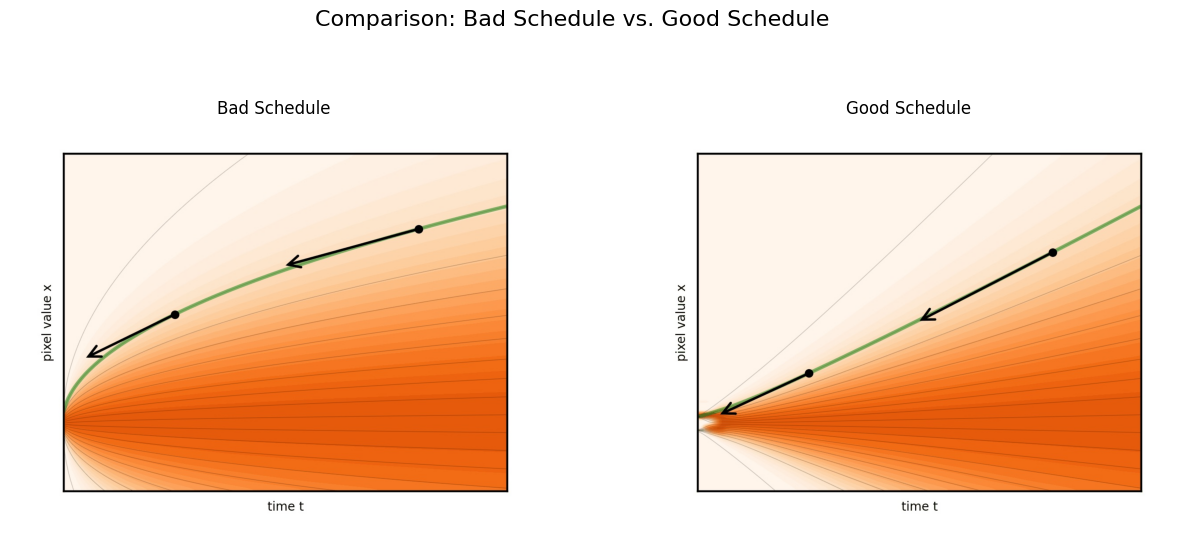

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 15 ,8

# read images
img_A = mpimg.imread('./figure/bad_schedule.jpeg')
img_B = mpimg.imread('./figure/good_schedule.jpeg')

# display images
fig, ax = plt.subplots(1, 2)

# Set titles for individual subplots
ax[0].set_title('Bad Schedule')
ax[1].set_title('Good Schedule')

# Display images
ax[0].imshow(img_A)
ax[0].axis('off')
ax[1].imshow(img_B)
ax[1].axis('off')

# Set a title for the entire figure
fig.suptitle('Comparison: Bad Schedule vs. Good Schedule', fontsize=16, y=0.9)

plt.show()


The optimal schedule corresponds to $\sigma(t)=t$ and $s(t)=1$. It's important to note that preconditioning the neural network is often preferable to scaling the ODE with $s(t)$. One reason for this preference is that scaling can introduce unwanted curvature into the model dynamics. Given these considerations, the ODE simplifies to:

$$
\begin{equation*}
d\mathbf{x}=-t \, \nabla_x \log p_t(\mathbf{x}) dt.
\end{equation*}
$$

This formulation implies that, for any given $x$ and $t$, a single Euler step towards $t = 0$ directly yields the denoised image. Consequently, the tangent of the solution trajectory consistently points towards the output of the denoiser.

We previously mentioned the necessity of taking shorter time steps to deal with high curvature. The methods reviewed in the paper uniformly adopt shorter steps at lower noise levels, precisely because these stages are critical for the construction of detailed features in the generated images. A convenient way to vary the local step size depending on the noise level is to define $\sigma_i$ as a linear resampling of some monotonically increasing, unbounded warp function $w(z)$. In other words,
$$
\sigma_{i<N} = w(Ai + B) \quad \text{and} \quad \sigma_N = 0,
$$
The variable $i$ represents the index of a specific step , starting from 0 and increasing to $N-1$, where $N$ is the total number of steps in the diffusion process.Constants $( A )$ and $( B )$ are selected so that $ \sigma_0 = \sigma_{\text{max}}$ and $ \sigma_{N-1} = \sigma_{\text{min}} $. A polynomial growing step length captures the essence of these schemes and so use a polynomial warp function $w(z) = z^\rho$ parameterized by the exponent $\rho$. This choice leads to the following formula for each time step:
$$
\sigma_{i<N} = \left(  \sigma_{\text{max}}^{1/\rho} + \frac{i}{N-1} \left( \sigma_{\text{min}}^{1/\rho} - \sigma_{\text{max}}^{1/\rho} \right) \right)^{\rho}, \quad \sigma_N = 0, 
$$

resulting in uniform discretization when $\rho = 1$. As $\rho$ increases, the emphasis on lower noise levels intensifies. To determine the optimal value of $\rho$, the authors plotted the FID (Fréchet Inception Distance) score against $\rho$ and discovered that the best performance is achieved at $\rho=7$.Similarly, for setting the minimum and maximum noise levels, $\sigma_{\text{min}} = \max(\sigma_{\text{lo}}, 0.002)$ and $\sigma_{\text{max}} = \min(\sigma_{\text{hi}}, 80)$, where $\sigma_{\text{lo}}$ and $\sigma_{\text{hi}}$ are the lowest and highest noise levels supported by a given model. These choices have been shown to perform reasonably well in practice.
The following implementation demonstrates how to apply this concept:

In [82]:
''' 
# Time step discretization.
step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho

# Adjust noise levels based on what's supported by the network.
sigma_min = max(sigma_min, net.sigma_min)
sigma_max = min(sigma_max, net.sigma_max)
'''

" \n# Time step discretization.\nstep_indices = torch.arange(num_steps, dtype=torch.float64, device=device)\nt_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho\n\n# Adjust noise levels based on what's supported by the network.\nsigma_min = max(sigma_min, net.sigma_min)\nsigma_max = min(sigma_max, net.sigma_max)\n"

There is one more thing that this ODE framework allows us to do (contrry to the markoc chain formulation) is the higher order solver. When there is hight curvature at some points so we can still fall of the trck if we just follow the tangent in the Euler method for exemple, this is what it's name the 'truncation error' and it can accumalte over the $N$ steps of our solver. But there is also Higher order scheme like Heun method where we take a second step and we moove it back where we started and the actuall is going to be the average of that and the initial one. Of course this has a cost, we have higher accuracy but a higher computational cost, the Heun's method showed a good tradeoff between precision and computational cost. 

One significant advantage of the ODE framework over the Markov chain formulation is its compatibility with higher-order solvers. In cases where the data trajectory is curved, following the tangent with a simple Euler method can lead to deviations from the intended path—known as 'truncation error'. This error may accumulate over the $N$ steps of the solver, potentially leading to significant inaccuracies.

However, higher-order schemes like the Heun method offer a solution. This method involves taking an initial Euler step, then a corrective step back towards the starting point. The final position is determined by averaging these two steps, effectively mitigating the initial approximation's potential overestimation or underestimation. 

While this approach yields higher accuracy, it also incurs a greater computational cost. Nevertheless, the Heun method demonstrates a favorable balance between precision and computational efficiency, making it a valuable tool for certain applications within the ODE framework.


This method is described formally as follows:

To solve the initial value problem given by:

$$y'(t) = f(t,y(t)), \qquad \qquad y(t_0)=y_0$$

Heun's method involves two main steps for each iteration from $y_i$ to $y_{i+1}$:

1. **Initial Prediction**: Compute an intermediate value $\tilde{y}_{i+1}$ using the Euler method as a predictor step:

   $$\tilde{y}_{i+1} = y_i + h f(t_i,y_i)$$

2. **Correction**: Calculate the final approximation $y_{i+1}$ at the next integration point by averaging the slope at the current point and the slope at the predicted next point:

   $$y_{i+1} = y_i + \frac{h}{2}[f(t_i, y_i) + f(t_{i+1},\tilde{y}_{i+1})],$$

where $h$ represents the step size, and $t_{i+1} = t_i + h$.

By initially predicting and then correcting, Heun's method effectively reduces the error that could arise from the function's curvature, offering a more accurate solution than the Euler method alone. This approach is especially useful in scenarios where precision is paramount.


<div>
<img src="https://developer-blogs.nvidia.com/wp-content/uploads/2023/12/heun-step-geometric-illustration.png" width="700"/>
</div>

<div class="alert alert-success"> 

**Code implementation**  

With the insights gained so far, we are now equipped to implement our own ODE sampler (outlined in Algorithm 1 of the main paper). By utilizing the Heun method alongside an appropriately chosen timestep, we can enhance the accuracy of our sampler. If you are interested in evaluating the performance difference, an argument `heun` can be set to `false` to revert the sampler to a basic Euler solver for comparison.However, it's important to adjust the number of steps (`num_steps`) by dividing it by 2 for a fair comparison between the Heun and Euler methods. This adjustment is necessary because the Heun method involves twice the computation of the Euler method, impacting both the computational cost and the accuracy of the results. This implementation is also compatible with your pre-trained neural network. You can find a list at the following link: [https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/](https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/). 

In [2]:
#The code takes about 5 min to run
def ODE_sampler(net, latents,num_steps=10, sigma_min=0.002, sigma_max=80, rho=7, heun=True, show=True, gridh=8, gridw=8):

    # You can choose your own sigma and s. 
    def sigma(t):
        return t  
    def s(t):
        return 1.0  
    def sigma_dot(t):
        return 1.0  
    def s_dot(t):
        return 0.0  
        
    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0
    
    x_next = latents.to(torch.float64) * sigma(t_steps[0]) * s(t_steps[0])
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        x_cur = x_next
        
        # Evaluate dx/dt at t_cur
        denoised = net(x_cur, t_cur).to(torch.float64)
        d_cur = (sigma_dot(t_cur)/sigma(t_cur) + s_dot(t_cur)/s(t_cur) )*x_cur  - ((sigma_dot(t_cur)*s(t_cur))/sigma(t_cur))*denoised
        
        # Take Euler step from t_cur to t_next
        x_temp = x_cur + (t_next - t_cur) * d_cur
        
        # Apply 2nd order correction with Heun's method
        if heun and sigma(t_next) != 0:
            denoised = net(x_temp/s(t_next), sigma(t_next)).to(torch.float64)
            d_next =(sigma_dot(t_next)/sigma(t_next) + s_dot(t_next)/s(t_next) )*x_temp  - ((sigma_dot(t_next)*s(t_next))/sigma(t_next))*denoised
            x_next = x_cur + (t_next - t_cur) * 0.5 * (d_cur + d_next)
        else:
            x_next = x_temp
        
        if show and (i%5==0):
            image = (x_next * 127.5 + 128).clip(0, 255).to(torch.uint8)
            image = image.reshape(gridh, gridw, *image.shape[1:]).permute(0, 3, 1, 4, 2)
            image = image.reshape(gridh * net.img_resolution, gridw * net.img_resolution, net.img_channels)
            image = image.cpu().numpy()
            pil_img= PIL.Image.fromarray(image, 'RGB')
            plt.imshow(pil_img)
            plt.title(f"Step {i+1}")
            plt.axis('off')  
            plt.show()
    
    return x_next


In [ ]:
gridw=8
gridh=8
batch_size = gridw * gridh 
torch.manual_seed(0)

# Loader of a pre-trained model
def load_pretrained_model(network_pkl):
    print('Loading network from {network_pkl}')
    with dnnlib.util.open_url(network_pkl) as f:
        net = pickle.load(f)['ema'].to(device)
    return net

#Load our network 
network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-vp.pkl'  # URL or path to your model
net = load_pretrained_model(network_pkl)
net.to(device) 

# Generate latents/noisy image.
print(f'Generating {batch_size} images...')
latents = torch.randn([batch_size, net.img_channels, net.img_resolution, net.img_resolution], device=device)


x_gen=ODE_sampler(net,latents,num_steps=15,heun=True,gridh=gridh, gridw=gridw)

# Plot the image grid.
image = (x_gen * 127.5 + 128).clip(0, 255).to(torch.uint8)
image = image.reshape(gridh, gridw, *image.shape[1:]).permute(0, 3, 1, 4, 2)
image = image.reshape(gridh * net.img_resolution, gridw * net.img_resolution, net.img_channels)
image = image.cpu().numpy()
pil_img= PIL.Image.fromarray(image, 'RGB')
plt.imshow(pil_img)
plt.title('Final image')
plt.axis('off')  
plt.show()



With some minor modifications, we can also visualize the pixel path transitioning from a noisy distribution to the desired one. This corresponds to the reverse paths depicted in previous figures. For simplification, we directly use $\sigma(t) = t$ and $s(t) = 1$:


In [71]:
def ODE_sampler_with_pixel_tracking(net, latents, tracked_pixels, num_steps=50, sigma_min=0.002, sigma_max=80, rho=7):
    
    device = latents.device
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho

    pixel_values_time = {pixel: [] for pixel in tracked_pixels}

    # Main sampling loop with pixel tracking
    x_next = latents.to(torch.float64)
    for i, t_cur in enumerate(t_steps):

        x_cur = x_next
        denoised = net(x_cur, t_cur).to(torch.float64)
        
        # Record the values of tracked pixels
        for pixel in tracked_pixels:
            pixel_value = x_cur[0, pixel[0], pixel[1], pixel[2]].item() 
            pixel_values_time[pixel].append(pixel_value)

        # Simplified update rule for demonstration; adjust based on your model's specifics
        x_next = denoised

    return pixel_values_time

In [ ]:
batch_size = 2*2 # Simplified to handle for tracking
latents = torch.randn([batch_size, net.img_channels, net.img_resolution, net.img_resolution], device='cpu')

# Specify 10 pixels to track across the image
img_resolution = net.img_resolution
tracked_pixels = [
    (0, 0, 0), 
    (0, img_resolution // 4, img_resolution // 4),  
    (0, img_resolution // 2, img_resolution // 2),  
    (0, 3 * img_resolution // 4, 3 * img_resolution // 4),  
    (0, img_resolution - 1, img_resolution - 1),  
]


# Perform ODE sampling and track pixel values
pixel_values_over_time = ODE_sampler_with_pixel_tracking(net, latents, tracked_pixels, num_steps=10)

# Plotting the pixel values over time
plt.figure(figsize=(12, 8))
for pixel, values in pixel_values_over_time.items():
    plt.plot(values, label=f'Pixel {pixel}')
plt.title('Pixel Value Changes Over Reverse ODE Steps')
plt.xlabel('Step')
plt.ylabel('Pixel Value')
plt.ylim(-0.5,0.5)
plt.legend()
plt.show()

## Elucidating Stochastic Sampling

Having addressed deterministic sampling, let's revisit the concept of Stochastic Differential Equations (SDEs). Unlike the smooth trajectories followed in deterministic approaches, SDEs introduce noise throughout the evolution of the process. A key reason for utilizing SDEs is their tendency to yield better results than ODEs in practice. Before exploring the reasons behind their effectiveness, let's first examine the formulation of SDEs. Thus, our reverse path will appear as follows:


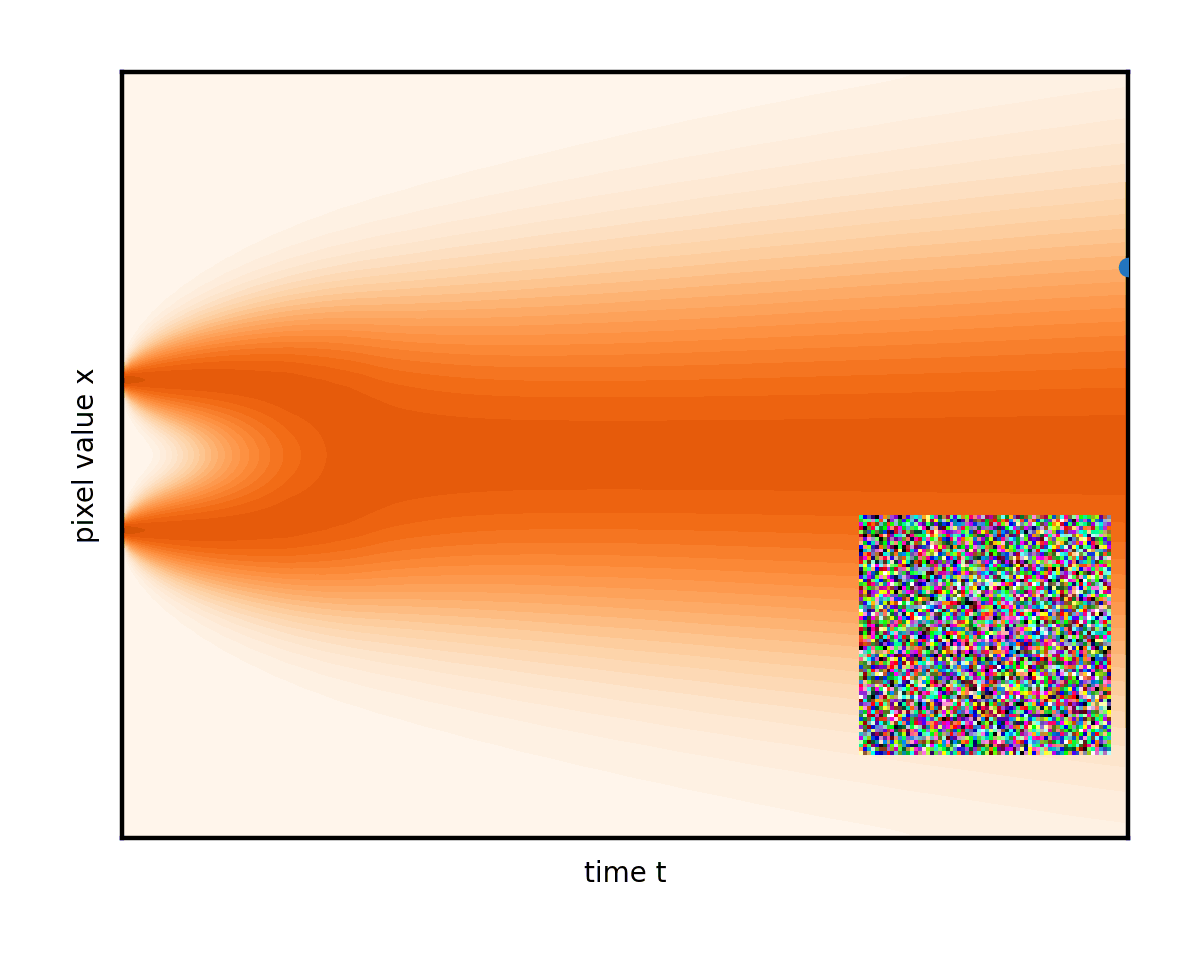

In [76]:
showImage('./figure/image8.gif', width=800)

The authors introduce a general Stochastic Differential Equation (SDE) that incorporates a noise replacement schedule, $\beta(t)$, a dynamic parameter that adjusts the intensity of noise interaction. For a detailed mathematical explanation, please refer to Appendix B.5 of the main article:

$$
dx_{\pm} = -\dot{\sigma}(t)\sigma(t)\nabla_x \log p(x; \sigma(t)) dt \pm \beta(t)\sigma(t)^2\nabla_x \log p(x; \sigma(t)) dt + \sqrt{2\beta(t)}\sigma(t) d\omega_t,
$$

Let's examine this equation in detail:

1. The first term, $-\dot{\sigma}(t)\sigma(t)\nabla_x \log p(x; \sigma(t)) dt$, represents the probability flow ODE discussed earlier. This component shapes the trajectories to ensure they pass through the desired distribution $p_t$ at time $t$, guiding the process towards the target state.

2. The second component, $\beta(t)\sigma(t)^2\nabla_x \log p(x; \sigma(t)) dt + \sqrt{2\beta(t)}\sigma(t) d\omega_t$, is known as the Langevin diffusion SDE. It facilitates random exploration of the distribution $p_t$ at time $t$, driving the samples towards it. The term $\beta(t)\sigma(t)^2\nabla_x \log p(x; \sigma(t)) dt$ acts as a deterministic noise decay mechanism, with $\beta(t)$ serving as a proportional factor for adding or removing noise. The choice of sign (forward with the $+$ or reverse SDE with the $-$) dictates the direction of noise adjustment. Meanwhile, $\sqrt{2\beta(t)}\sigma(t) d\omega_t$ introduces stochastic noise injection into the process.

Understanding these components reveals why an SDE might be preferable over a simple ODE for certain applications in generative modeling. Let's consider the extreme situation where our samples are poorly distributed and do not align with the underlying distribution at all, being skewed to one side (with the normal distribution shown in red). If we adhere strictly to the ODE path, we completely miss the other base of the data. However, by introducing stochasticity into this process, the samples undergo random exploration and gradually diverge from their initial biased state. Thus, SDEs exhibit a sort of "healing" property through Langevin exploration, allowing for a more thorough and unbiased coverage of the data distribution.


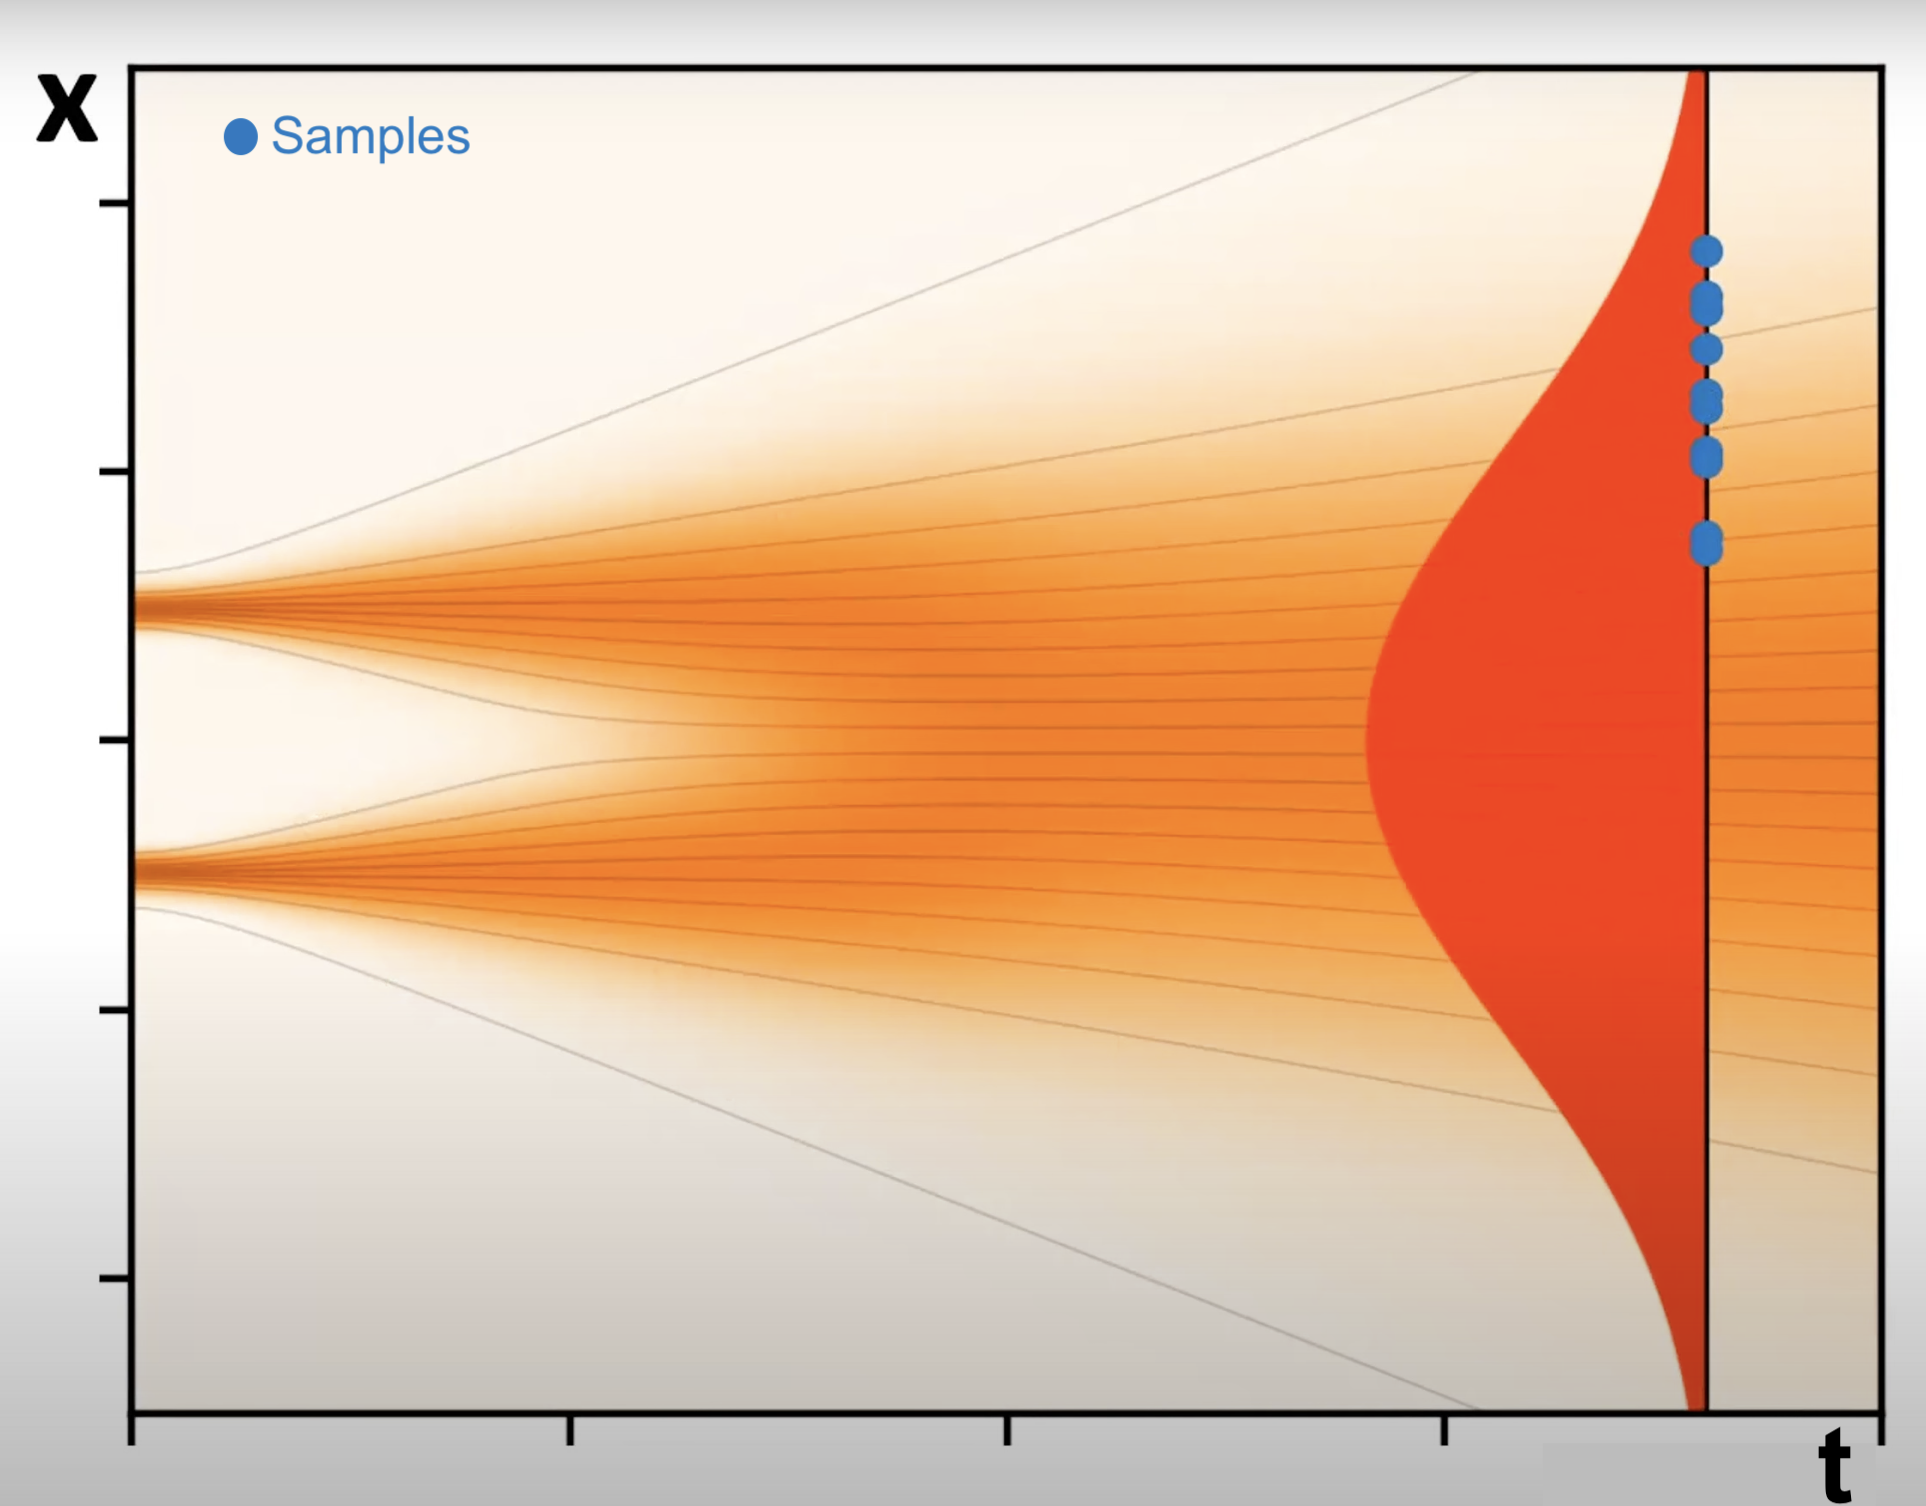

In [53]:
showImage('/Users/vakili/Documents/projetDEEP/bad_distributed_samples.png',width=700)

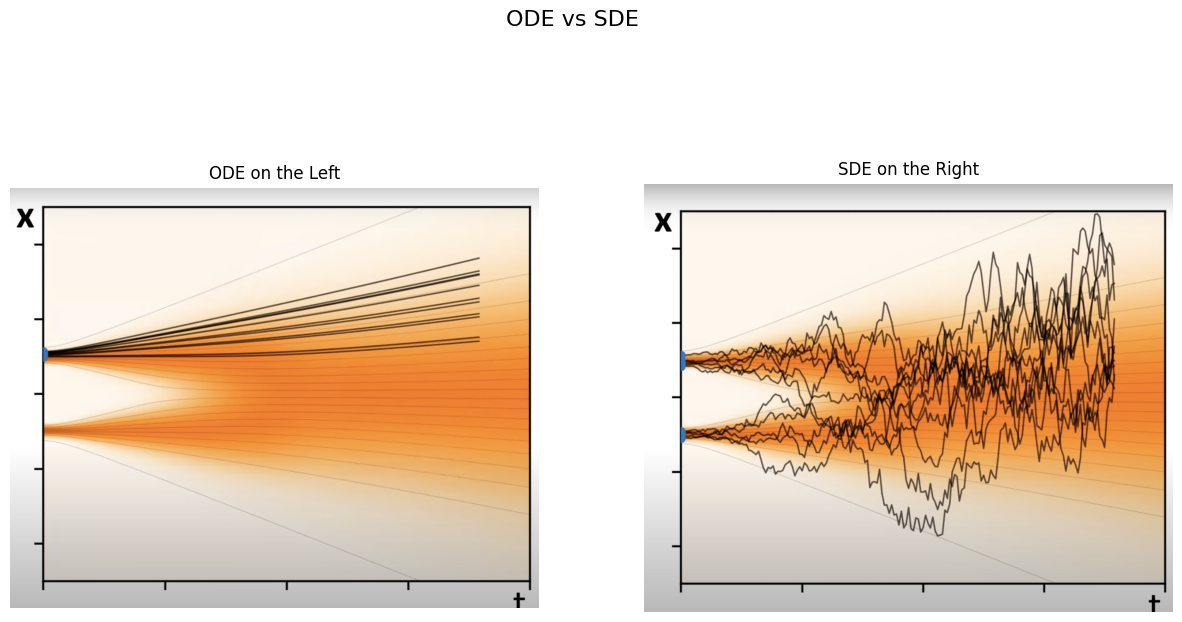

In [80]:
rcParams['figure.figsize'] = 15, 8
img_A = mpimg.imread('./figure/ODE_bad_samples.png')
img_B = mpimg.imread('./figure/SDE_bad_samples.png')
fig, ax = plt.subplots(1, 2)
fig.suptitle('ODE vs SDE', fontsize=16)

ax[0].imshow(img_A)
ax[0].set_title('ODE', fontsize=12)  
ax[0].axis('off')


ax[1].imshow(img_B)
ax[1].set_title('SDE', fontsize=12)  
ax[1].axis('off')

plt.show()


Instead of relying on complex SDE solvers, the authors propose a novel method that synergizes higher-order ODE solvers with Langevin diffusion, introducing their own stochastic sampler. The process for this approach at each time step $i$ is as follows:

1. Starting with a noisy image $x_i$ at time $t_i$, additional noise is added to achieve the noise level at time $\gamma_i t_i$, resulting in a new image $\hat{x}_i$. Here, $\gamma_i$ denotes the Langevin strength.

2. The process then advances to the next time step at $t_{i+1}$ (noting that we are progressing from right to left, hence $t_{i+1} < t_i$) using a single Heun step. This step incrementally moves the system closer to time 0, incorporating stochasticity but fundamentally solving an ODE at each step.

It's important to recognize that while the introduction of stochasticity can correct certain errors, it may also introduce new ones due to the Langevin step being a discrete approximation of a continuous object. Thus, finding the right balance between precision and stochastic exploration is key and typically determined empirically.

If degradation is observed, particularly due to inaccuracies in $D_{\theta} (x; \sigma)$, it can be addressed through heuristic adjustments during sampling. The authors propose to enable stochasticity exclusively within a specific range of noise levels $t_i \in [St_{\text{min}}, St_{\text{max}}]$. For these noise levels, $\gamma_i$ is set as $Schurn/N$, where $Schurn$ adjusts the overall level of stochasticity introduced. 

The implementation of this method is detailed as Algorithm 2 in the main article.

<div class="alert alert-success"> 

**Code Implementation**  
You can, of course, reuse this sampler with your other neural networks and experiment with different parameters to see what happens.


In [5]:
def SDE_sampler(net, latents, randn_like=torch.randn_like,num_steps=15, sigma_min=0.002, sigma_max=80, rho=7, S_churn=0, S_min=0, S_max=float('inf'), S_noise=1,show=True):

    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = latents.to(torch.float64) * t_steps[0]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
        t_hat = net.round_sigma(t_cur + gamma * t_cur)
        x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * randn_like(x_cur)

        # Euler step.
        denoised = net(x_hat, t_hat).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur

        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next, t_next).to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)
        if show and (i%5==0):
            image = (x_next * 127.5 + 128).clip(0, 255).to(torch.uint8)
            image = image.reshape(gridh, gridw, *image.shape[1:]).permute(0, 3, 1, 4, 2)
            image = image.reshape(gridh * net.img_resolution, gridw * net.img_resolution, net.img_channels)
            image = image.cpu().numpy()
            pil_img= PIL.Image.fromarray(image, 'RGB')
            plt.imshow(pil_img)
            plt.title(f"Step {i+1}")
            plt.axis('off')  
            plt.show()

    return x_next

In [ ]:
gridw=8
gridh=8
batch_size = gridw * gridh 
torch.manual_seed(0)

# Loader of a pre-trained model
def load_pretrained_model(network_pkl):
    print('Loading network from {network_pkl}')
    with dnnlib.util.open_url(network_pkl) as f:
        net = pickle.load(f)['ema'].to(device)
    return net

#Load our network 
network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-vp.pkl'  # URL or path to your model
net = load_pretrained_model(network_pkl)
net.to(device) 

# Generate latents/noisy image.
print(f'Generating {batch_size} images...')
latents = torch.randn([batch_size, net.img_channels, net.img_resolution, net.img_resolution], device=device)


x_gen=SDE_sampler(net,latents,num_steps=15) #We use the SDE sampler

# Plot the image grid.
image = (x_gen * 127.5 + 128).clip(0, 255).to(torch.uint8)
image = image.reshape(gridh, gridw, *image.shape[1:]).permute(0, 3, 1, 4, 2)
image = image.reshape(gridh * net.img_resolution, gridw * net.img_resolution, net.img_channels)
image = image.cpu().numpy()
pil_img= PIL.Image.fromarray(image, 'RGB')
plt.imshow(pil_img)
plt.title('Final image')
plt.axis('off')  
plt.show()



The results obtained from the stochastic differential equation (SDE) approach initially seem worse than those from the standard ordinary differential equation (ODE)! Specifically, with a low number of steps, the outcomes are not as favorable as those achieved with a simple ODE. However, it requires a greater number of time steps (exceeding 60) for an SDE to surpass the performance of an ODE. Yet, at a high number of time steps, SDE significantly outperforms a simple ODE. If you have some extra time, experimenting with both methods and comparing their results can offer valuable insights.

It is notable that the implementation of these design choices in the sampling process alone has led the authors to achieve state-of-the-art results on the ImageNet-64 dataset!


# The Neural Denoiser, aka Score Function

## Network and Preconditioning 

Remind yourself of the two sources of error we've discussed; we've addressed the first one in the previous sections. Now, let's focus on the neural network, exploring how to train and parameterize them to obtain a reliable estimator for guiding the direction of each step. We'll not delve into the architecture itself. Let's recall the role of the neural network in this context:

- The ODE step $-t \nabla_x \log(p_t(x))dt$ utilizes the score function $\nabla_x \log(p_t(x))$.
- This can be computed using a denoiser $D(x;t)$, thus transforming the ODE step into $\frac{1}{t}(x-D(x;t))$.
- In practice, $D(x;t)$ is approximated using a Convolutional Neural Network (CNN), usually a U-net architecture.

The first point, which we've already discussed previously, is as follows: Since we are manipulating noisy images with a high range of variation in pixel values (e.g., -100 to 100) and clean images with a low range of variation in pixel values (e.g., -1 to 1), this discrepancy raises a red flag. Neural networks are known to suffer from unstable training and poor final performance due to such discrepancies. Traditionally, neural networks were simply connected to the input of the network to process the image and then read the denoised image from its output layer. However, what we aim for instead is to implement management layers that can handle the signal scales of both the input and the output to standardize them in some way.

The denoiser is typically approximated using a Convolutional Neural Network (CNN), with the output compared to the clean image using a mean squared loss. The training involves taking a random training sample and introducing noise at a random strength. Considering the architecture proposed in Variance Exploding (VE) methods, in that case the models learn to predict the noise instead of the signal through the CNN layers. This raises an important question: should the network be trained to predict the signal or the noise? (We will address this query later).

we can interpret this model as having a skip connection between the input of the CNN and the output of the CNN. The noisy input passes through the CNN, which is implicitly tasked with predicting the negative of the noise component in the image. Then, there is an explicit layer that scales this noise to the known noise level. Consequently, when you add the output from the skip connection to this, you obtain an estimate of the clean image. In this manner, the CNN focuses on the noise rather than the signal itself. I will explain soon why this is relevant.

However, before delving into that, let's address the challenge posed by the vast variations in the numerical magnitude of these signals. The architecture as described fails to accommodate such variations, which is problematic. A simple solution is to introduce an input scaling layer that utilizes the known standard deviation of the noise to scale down the image. It is simply a scaling based on our knowledge of the noise level and the expected signal magnitude.

By implementing this strategy, we tackle one of the initial issues highlighted in this discussion. On the output side, we already have a beneficial setup: the network only needs to produce an output with unit standard deviation. The explicit scaling to the known noise level simplifies the application of the actual noise magnitude, making the task much easier for the neural network. To summarize, here's an overview of our Denoiser architecture:


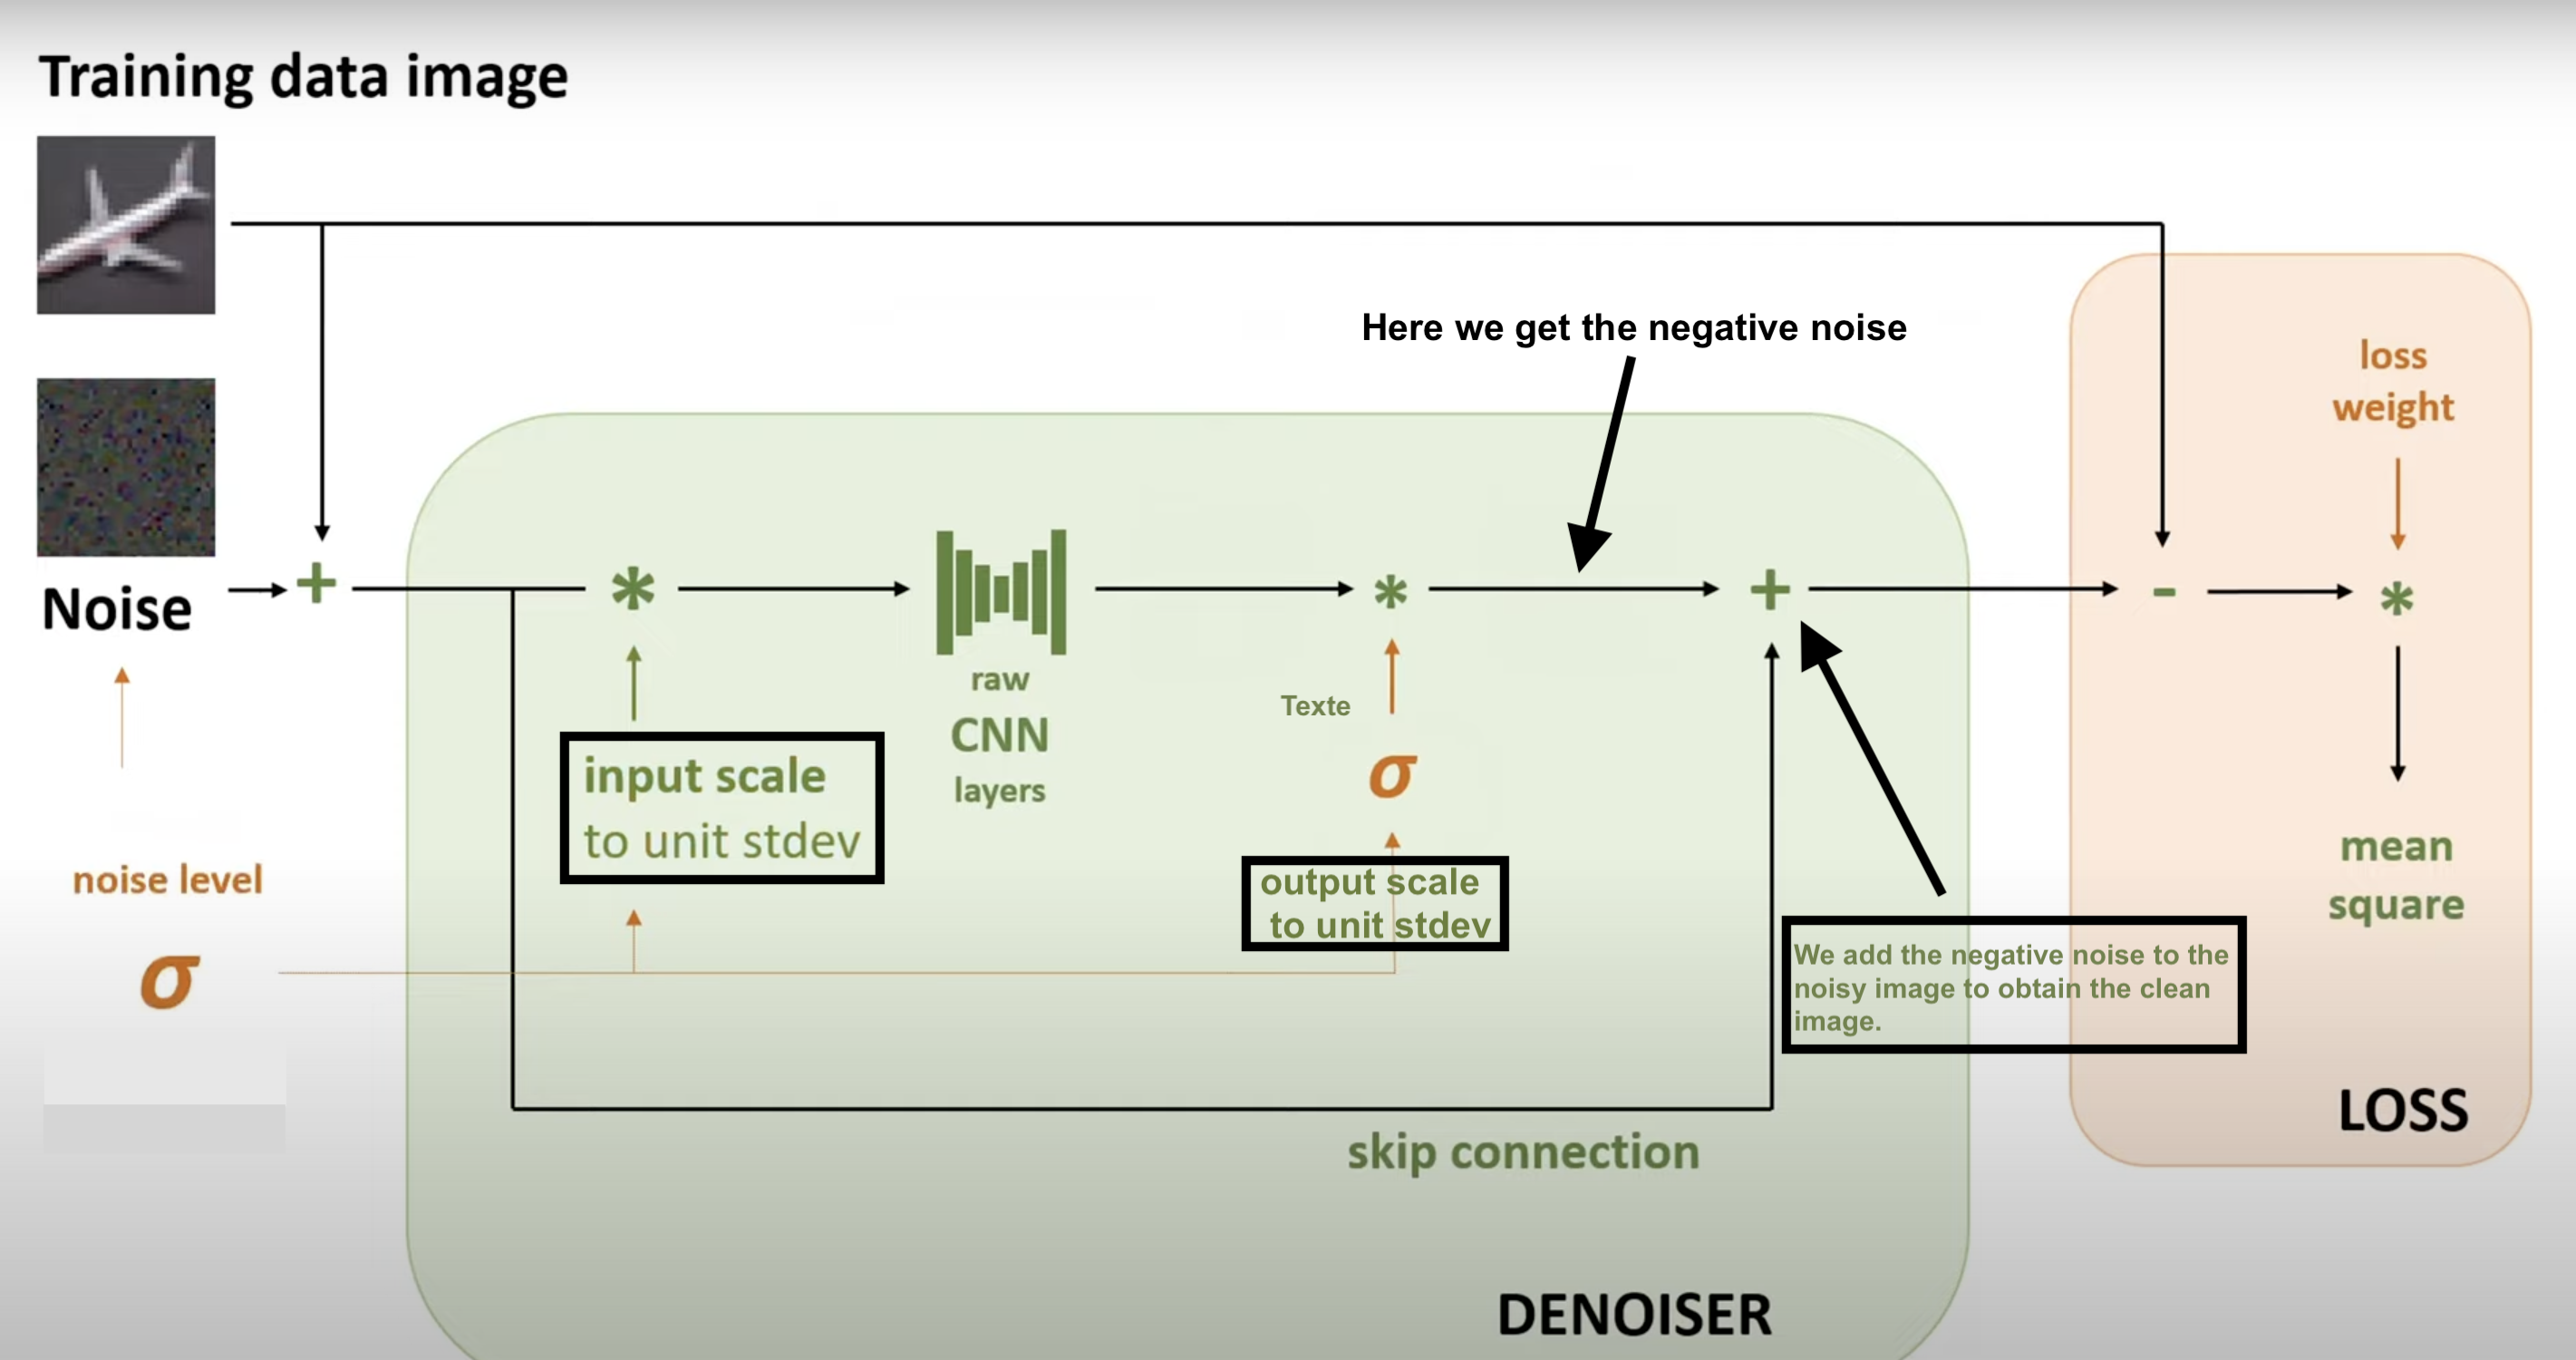

In [90]:
showImage('./figure/Denoiser_1.png')

The previous Denoiser attempts to predict the noise in the image, but is this approach always beneficial? Consider when we have a large $\sigma$, resulting in a very high noise level. In such cases, the noisy image essentially becomes equivalent to the noise itself and similarly for the output of the CNN network, which represents the inverse of the noise. Consequently, when subtracting these two images to obtain our predicted image, since we are dealing with two highly noisy images, we attempt to subtract two substantial signals in hopes of deriving a normal-sized signal, which leads to poor results. Instead, what we desire is to deactivate the skip connection, allowing the CNN's task to be directly predicting the image without the need to scale it to unit standard deviation.

To summarize: if our standard deviation is high, we aim to directly predict the image; conversely, if our noise level is low, we aim to predict the noise.

To facilitate this, we can introduce a continuous switch called 'skip scale' to cancel the skip connection,a value between 0 and 1, depending on the noise level. When its value is 0, the skip connection is completely canceled; when it's 1, the skip connection is fully active; and when it's in between, we predict a mixture of noise and signal. Thus, the output of the denoiser can be represented as:

$$ D_{\theta}(x;t)=c_{skip} \cdot noisy\_image + c_{out} \cdot network_{output}(scaled\_noisy\_image, \sigma).$$

$c_{skip}(\sigma)$ modulates the skip connection, while $c_{in}(\sigma)$ and $c_{out}(\sigma)$ adjust the input and output magnitudes, respectively, and $c_{noise}(\sigma)$ translates the noise level $\sigma$ into a conditioning input for our raw neural network.

Additionally, we can express the new Loss function using this formalism, clearly illustrating that by setting $c_{skip}$ to zero, we train our model to predict the clean image, and by setting it to one, we train our model to predict the noise:

$$
\mathbb{E}_{\sigma, \boldsymbol{y}, \boldsymbol{n}}\left[\lambda(\sigma) c_{\text {out}}(\sigma)^2\left\|F_\theta\left(c_{\text {in}}(\sigma) \cdot(\boldsymbol{y}+\boldsymbol{n}) ; c_{\text {noise}}(\sigma)\right)-\frac{1}{c_{\text {out}}(\sigma)}\left(\boldsymbol{y}-c_{\text {skip}}(\sigma) \cdot(\boldsymbol{y}+\boldsymbol{n})\right)\right\|_2^2\right]
$$

Here, $\mathbf{n}$ is the noise, and $\mathbf{y}$ is the clean image. which aren't very complicated mathematically, if you'd like to take a look please refer at appendix B.6 of the main article.

With this knowledge, we elucidate two other parameters, and our table now looks like this:



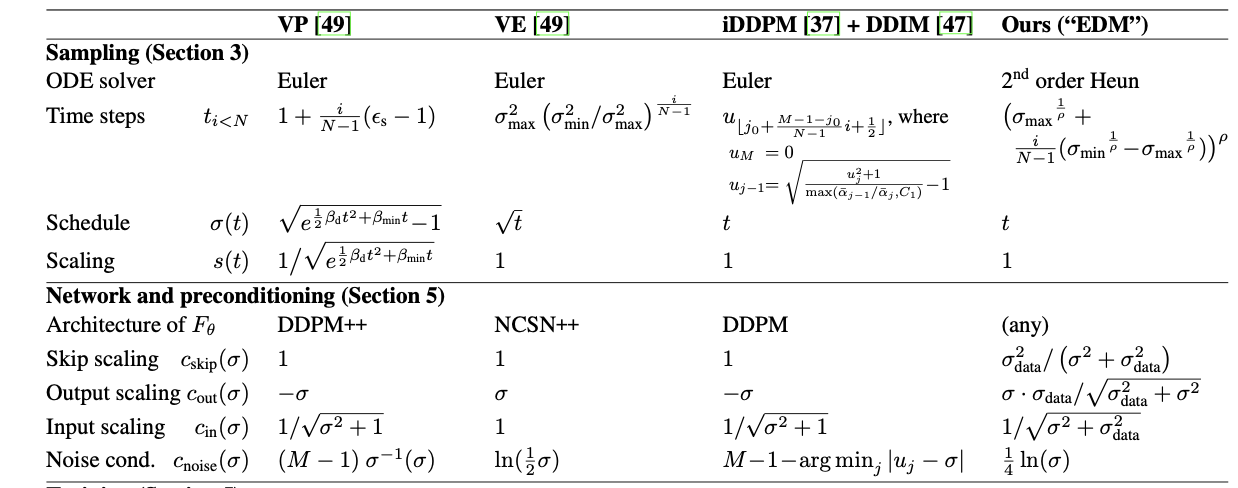

In [93]:
showImage('./figure/recap_table_2.png',width=900)

## Training and Loss

When examining the denoiser's scheme, you'll notice that there is a weight applied just before computing the mean square error. Let's explore why this adjustment is necessary: The challenge arises because the magnitude of the loss varies significantly across different noise levels due to the internal scalings within the denoiser. As a result, the magnitude of the updates (gradient feedback) to the network weights is also noise-level dependent. This variability is similar to  using different learning rates for different noise levels without any justified reason.

This scenario underscores the importance of normalizing the magnitudes to achieve more stable and successful training. Thankfully, a straightforward data-independent statistical formula can predict the expected loss magnitude for each noise level, allowing weights to be adjusted to normalize this magnitude back to 1.

However, the same goal can be achieved without impacting the magnitudes by training more frequently at those important noise levels. This concept is illustrated in the following image:

![backprop](https://developer-blogs.nvidia.com/wp-content/uploads/2023/12/noise-level-distribution-before-after-diagram.png)

Throughout training, each noise level contributes gradient updates (represented by arrows) to the network weights. We can separately manage the magnitudes and counts of these updates using two distinct mechanisms. By default, both the magnitude (length of the arrows) and frequency (number of arrows) of updates are uncontrolled and vary with the noise level. The team proposes a division of labor where loss scaling normalizes the update magnitudes, and the noise level distribution dictates the frequency of training at each level.

At very low noise levels, progress is minimal because predicting the noise from an almost noise-free image is nearly impossible (and arguably unnecessary). In contrast, at very high noise levels, optimal denoising (which might resemble a blurry average of dataset images) is relatively straightforward to predict. The intermediate range offers a wide spectrum of noise levels where significant progress can be achieved.

In practice, the random training noise levels are selected following a log-normal distribution $ \sigma = \exp(P_{\text{mean}} + P_{\text{std}} \cdot \text{randn}()) $, where $P_{\text{mean}}$ and $P_{\text{std}}$ determine the average noise level for training and the variance around that mean, respectively.

Hooray! We have completed the elucidation of the design space of Diffusion-Based Models:


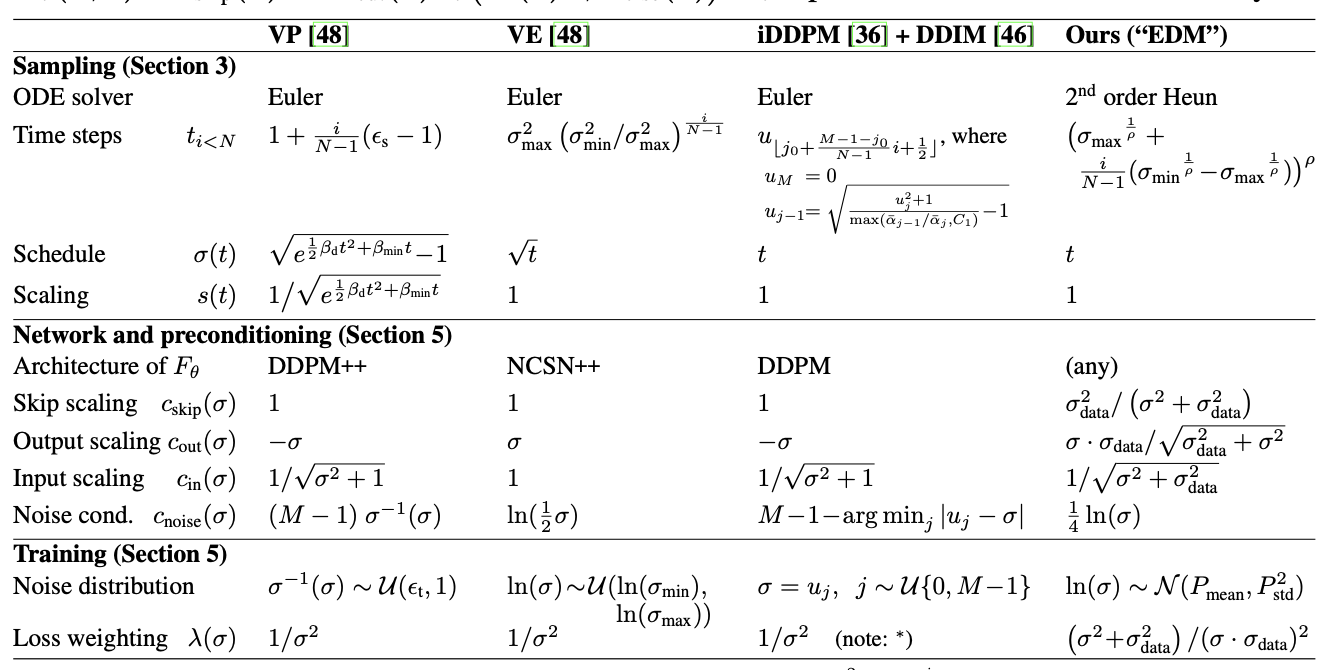

In [96]:
showImage('./figure/recap_table_3.png', width=900)

<div class="alert alert-success"> 

**Code Implementation**  

Now, let's proceed with the implementation of these classes. First, we will implement the class associated with the loss function, incorporating the optimal parameter as specified in the main article. Please pay attention to the distribution of sigma and the weighting of the loss.

In [102]:
#Class associated to the loss function with the correct parameters
class EDMLoss:
    def __init__(self, P_mean=-1.2, P_std=1.2, sigma_data=0.5):
        self.P_mean = P_mean
        self.P_std = P_std
        self.sigma_data = sigma_data

    def __call__(self, net, images):
        rnd_normal = torch.randn([images.shape[0], 1, 1, 1], device=images.device)

        sigma = (rnd_normal * self.P_std + self.P_mean).exp() #log normal Noise Distribution

        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2 # Compute th weight for the loss

        y = images
        n = torch.randn_like(y) * sigma # the noise 
        sigma_flat = sigma.flatten() 
        D_yn = net(y + n, sigma_flat)

        loss = weight * ((D_yn - y) ** 2) # Loss weighting
        return loss


On the other hand, we will now focus on implementing enhancements to the neural network for a specific underlying model. For this purpose, we have selected the U-Net architecture, which is notably popular in the literature on diffusion models. In the implementation referenced in the main article, they utilize a previously established neural network architecture. It's important to note that we will not be training our neural network in this example, as it requires significant computational resources. However, for those interested in exploring further, you can refer to the training script available at https://github.com/NVlabs/edm/blob/main/train.py .

In [101]:
class EDMPrecond(torch.nn.Module):
    def __init__(self,
        img_resolution = (32,32),           # Image resolution.
        img_channels = 3,                   # Number of color channels.
        sigma_min       = 0,                # Minimum supported noise level.
        sigma_max       = float('inf'),     # Maximum supported noise level.
        sigma_data      = 0.5,              # Expected standard deviation of the training data.
        model_type      = 'UNet2DModel',    # Class name of the underlying model. 
        **model_kwargs,                     # Keyword arguments for the underlying model.
    ):
        super().__init__()
        self.img_resolution = img_resolution
        self.img_channels = img_channels
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.sigma_data = sigma_data
        self.model = globals()[model_type](sample_size=img_resolution, in_channels=img_channels, out_channels=img_channels, block_out_channels=(32, 64, 128, 256) ,**model_kwargs) #Set the parameter of the underlying model. 

    def forward(self, x, sigma, **model_kwargs):
        x = x.to(torch.float32)
        sigma = sigma.to(torch.float32).reshape(-1, 1, 1, 1)
        dtype = torch.float32

        #We compute all the required c
        c_skip = self.sigma_data ** 2 / (sigma ** 2 + self.sigma_data ** 2)
        c_out = sigma * self.sigma_data / (sigma ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4

        unet_output = self.model((c_in * x).to(dtype), c_noise.flatten() ,sigma, **model_kwargs) #Output of the underlaying model

        F_x = unet_output.sample
        F_x = F_x.to(dtype)
        D_x = c_skip * x + c_out * F_x.to(torch.float32)
        
        return D_x


## Conclusion

To summarize everything we've covered: Training, sampling, and network architectures are distinct elements that can be analyzed and improved independently. The thoughtful design of each of these modules contributes to enhancements at every stage. Utilizing stochasticity in the process has both advantages and disadvantages.

With all these improvements implemented sequentially, the paper achieved state-of-the-art results at the time of publication. They evaluated their results using the [FID (Fréchet Inception Distance)](https://en.wikipedia.org/wiki/Fréchet_inception_distance) metric, which compares the distribution of generated images to the distribution of a set of real images.

The team has also recently published a follow-up research paper, [Analyzing and Improving the Training Dynamics of Diffusion Models](https://arxiv.org/abs/2312.02696), that continues the exploration beyond the scope of this post.


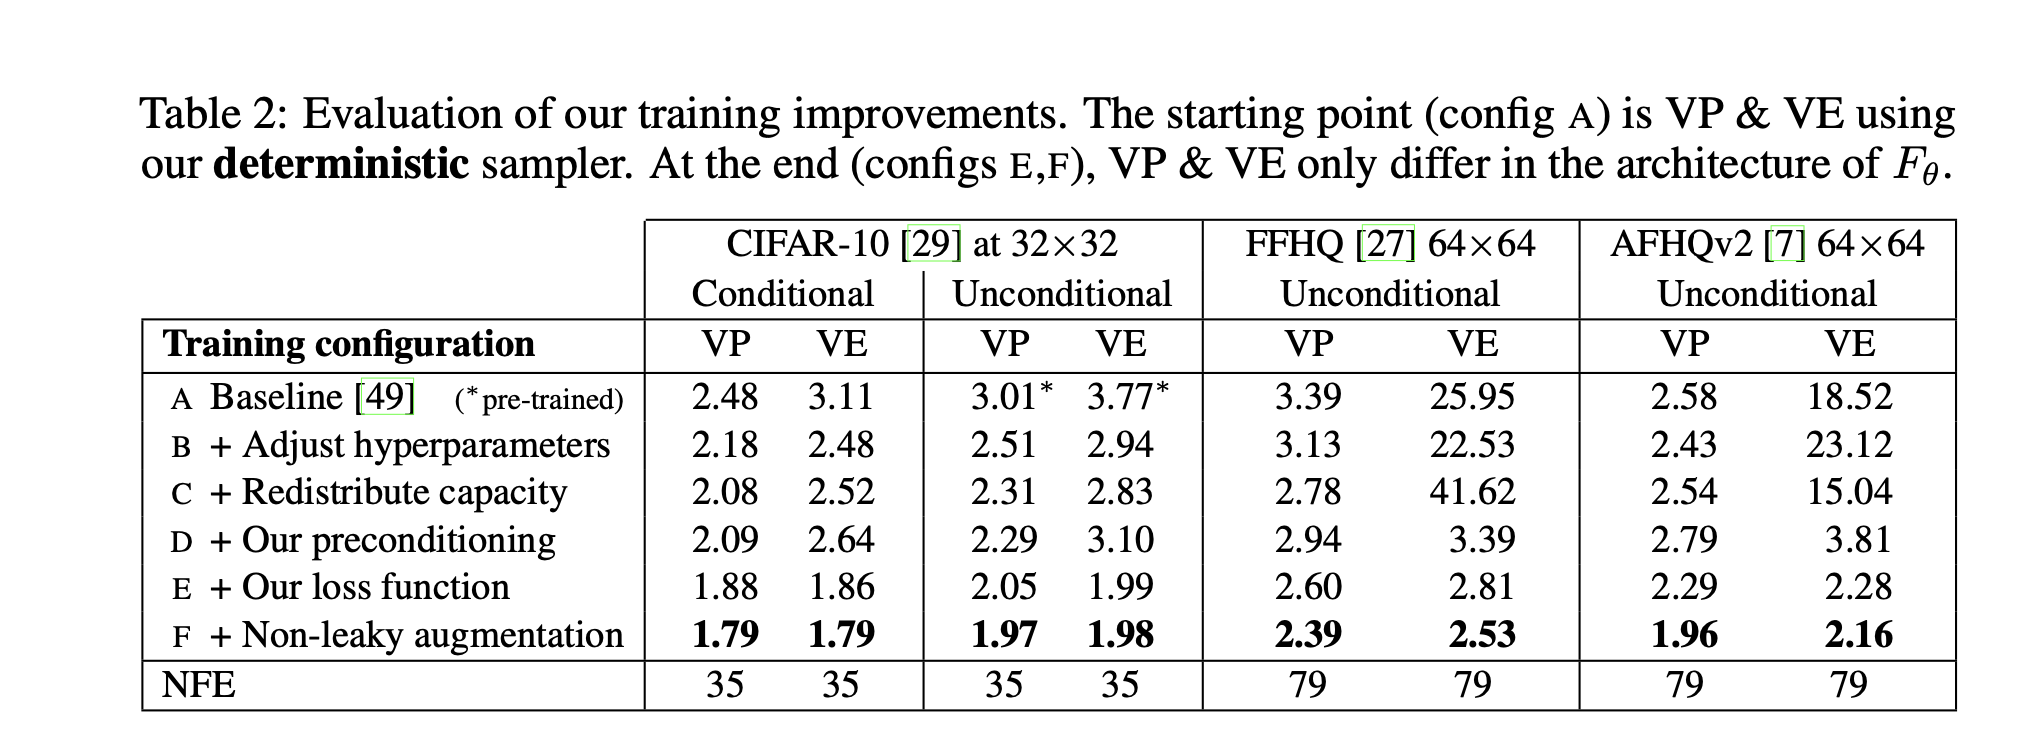

In [100]:
showImage('./figure/Resultat.png', width=1000)


**Sources**

- Yong Song's blog on diffusion models: [http://yang-song.net/blog/2021/score/#score-based-generative-modeling-with-stochastic-differential-equations-sdes](http://yang-song.net/blog/2021/score/#score-based-generative-modeling-with-stochastic-differential-equations-sdes)
- Blog associated with this article, where the majority of my figures come from: [https://developer.nvidia.com/blog/generative-ai-research-spotlight-demystifying-diffusion-based-models/](https://developer.nvidia.com/blog/generative-ai-research-spotlight-demystifying-diffusion-based-models/)
- The code provided by the authors of the article: [https://github.com/NVlabs/edm/tree/main](https://github.com/NVlabs/edm/tree/main)
- A practical application of this implementation to enhance an existing model by FastAI: [https://course.fast.ai/Lessons/lesson22.html](https://course.fast.ai/Lessons/lesson22.html)
